In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 15,15
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm ,tnrange

In [215]:
train = pd.read_csv("train_wn75k28.csv")

In [203]:
test = pd.read_csv("test_Wf7sxXF.csv")
submission = pd.read_csv("sample_submission_2zvVjBu.csv")

In [169]:
train.tail()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
39156,39157,2021-12-31,11,11,2.0,2017-10-19,1,0,0,0,1,1,1,0,0,0,0,0,0
39157,39158,2021-12-31,3,9,3.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
39158,39159,2021-12-31,8,7,2.0,NaN,1,0,0,0,1,0,1,0,0,0,0,0,0
39159,39160,2021-12-31,7,12,2.0,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0
39160,39161,2021-12-31,2,5,NaN,2019-08-11,1,0,0,0,0,0,1,0,0,0,0,0,0


In [170]:
test.head()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12
0,39162,2022-01-01,2,2,NaN,2021-08-17,1,1,0,0,0,1,0,0,0,0,1,0
1,39163,2022-01-01,4,7,3.0,2020-05-21,1,0,0,0,0,0,0,1,0,0,0,0
2,39164,2022-01-01,8,7,NaN,NaN,0,0,0,0,1,1,0,0,0,0,0,0
3,39165,2022-01-01,9,8,2.0,2020-06-22,0,0,0,0,1,1,1,0,0,0,2,0
4,39166,2022-01-01,4,5,2.0,2021-03-10,1,0,0,0,0,0,0,0,0,0,0,0


In [171]:
train.isnull().sum()/train.shape[0]

id                      0.000000
created_at              0.000000
campaign_var_1          0.000000
campaign_var_2          0.000000
products_purchased      0.533975
signup_date             0.385920
user_activity_var_1     0.000000
user_activity_var_2     0.000000
user_activity_var_3     0.000000
user_activity_var_4     0.000000
user_activity_var_5     0.000000
user_activity_var_6     0.000000
user_activity_var_7     0.000000
user_activity_var_8     0.000000
user_activity_var_9     0.000000
user_activity_var_10    0.000000
user_activity_var_11    0.000000
user_activity_var_12    0.000000
buy                     0.000000
dtype: float64

In [172]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,39161.0,19581.000000,11304.951283,1.0,9791.0,19581.0,29371.0,39161.0
campaign_var_1,39161.0,6.523812,3.472944,1.0,4.0,6.0,9.0,16.0
campaign_var_2,39161.0,6.452746,2.614296,1.0,5.0,6.0,8.0,15.0
products_purchased,18250.0,2.154137,0.779815,1.0,2.0,2.0,3.0,4.0
user_activity_var_1,39161.0,0.400092,0.509194,0.0,0.0,0.0,1.0,3.0
user_activity_var_2,39161.0,0.006716,0.081676,0.0,0.0,0.0,0.0,1.0
user_activity_var_3,39161.0,0.102832,0.303743,0.0,0.0,0.0,0.0,1.0
user_activity_var_4,39161.0,0.011465,0.106463,0.0,0.0,0.0,0.0,1.0
user_activity_var_5,39161.0,0.151503,0.359681,0.0,0.0,0.0,0.0,2.0
user_activity_var_6,39161.0,0.499834,0.558166,0.0,0.0,0.0,1.0,3.0


In [216]:
train_df.dtypes

campaign_var_1            int64
campaign_var_2            int64
user_activity_var_1       int64
user_activity_var_2       int64
user_activity_var_3       int64
user_activity_var_4       int64
user_activity_var_5       int64
user_activity_var_6       int64
user_activity_var_7       int64
user_activity_var_8       int64
user_activity_var_9       int64
user_activity_var_10      int64
user_activity_var_11      int64
user_activity_var_12      int64
ir                      float64
cv                        int64
day                       int64
date                      int64
month                     int64
dow                       int64
cv1                       int32
cv2                       int32
dtype: object

In [202]:
test_df.dtypes

campaign_var_1            int64
campaign_var_2            int64
products_purchased      float64
user_activity_var_1       int64
user_activity_var_2       int64
user_activity_var_3       int64
user_activity_var_4       int64
user_activity_var_5       int64
user_activity_var_6       int64
user_activity_var_7       int64
user_activity_var_8       int64
user_activity_var_9       int64
user_activity_var_10      int64
user_activity_var_11      int64
user_activity_var_12      int64
ir                      float64
cv                        int64
day                       int64
date                      int64
month                     int64
dow                       int64
cv1                       int32
cv2                       int32
dtype: object

In [175]:
train.buy.value_counts()

0    37163
1     1998
Name: buy, dtype: int64

In [217]:
test['products_purchased']=test['products_purchased'].fillna(2.0)

In [218]:
train['products_purchased']=train['products_purchased'].fillna(2.0)

In [219]:
train[train.buy==1].head(20)

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
144,145,2021-01-05,4,5,2.0,2019-02-12,1,0,1,1,1,1,0,0,0,0,0,0,1
159,160,2021-01-05,5,7,3.0,2016-03-11,1,0,0,0,1,1,1,0,0,0,0,0,1
173,174,2021-01-05,6,3,2.0,2020-11-13,0,1,0,0,1,0,0,0,0,0,0,0,1
178,179,2021-01-06,8,9,2.0,2018-07-23,1,0,0,1,1,0,0,0,1,0,0,0,1
274,275,2021-01-08,3,4,2.0,2020-03-01,1,0,0,0,1,0,0,0,1,0,0,0,1
305,306,2021-01-09,5,7,2.0,2021-05-27,1,0,0,0,0,0,0,0,0,0,0,0,1
307,308,2021-01-09,1,2,2.0,2017-04-18,0,0,0,0,0,1,0,0,0,0,0,0,1
326,327,2021-01-10,3,6,2.0,2017-01-10,0,0,0,1,0,1,0,0,0,0,0,0,1
342,343,2021-01-10,2,5,1.0,2019-01-17,0,0,0,0,1,0,0,0,1,0,1,0,1
345,346,2021-01-10,5,8,2.0,2020-06-05,1,0,0,1,0,1,0,0,0,0,0,0,1


<AxesSubplot:>

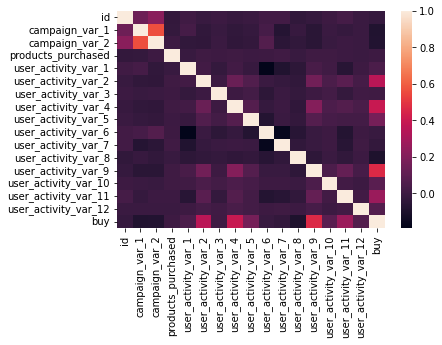

In [179]:
import seaborn as sns
corr = train.corr()
sns.heatmap(corr)

<AxesSubplot:>

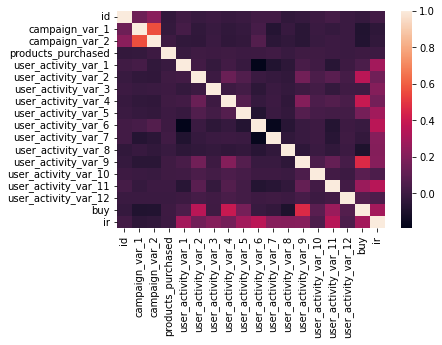

In [181]:
corr = train.corr()
sns.heatmap(corr)

<AxesSubplot:>

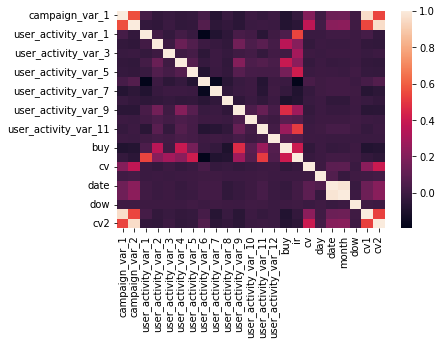

In [125]:
corr = df.corr()
sns.heatmap(corr)

In [220]:
train['ir']= np.exp(train['user_activity_var_1']) +np.exp(train['user_activity_var_2']) +np.exp(train['user_activity_var_3'])  +np.exp(train['user_activity_var_4']) +np.exp(train['user_activity_var_5']) + np.exp(train['user_activity_var_9']) +np.exp(train['user_activity_var_10']) +np.exp(train['user_activity_var_11']) +np.exp(train['user_activity_var_12'])


In [205]:
test['ir']= np.exp(test['user_activity_var_1']) +np.exp(test['user_activity_var_2']) +np.exp(test['user_activity_var_3'])  +np.exp(test['user_activity_var_4']) +np.exp(test['user_activity_var_5']) + np.exp(test['user_activity_var_9']) +np.exp(test['user_activity_var_10']) +np.exp(test['user_activity_var_11']) +np.exp(test['user_activity_var_12'])


In [221]:
train['cv']=2^(train['campaign_var_1'])-2^(train['campaign_var_2'])

In [206]:
test['cv']=2^(test['campaign_var_1'])-2^(test['campaign_var_2'])

<AxesSubplot:xlabel='buy', ylabel='campaign_var_1'>

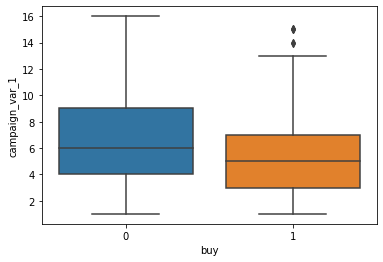

In [53]:
sns.boxplot(y= 'campaign_var_1' , x = 'buy' , data = train)

<AxesSubplot:xlabel='buy', ylabel='campaign_var_2'>

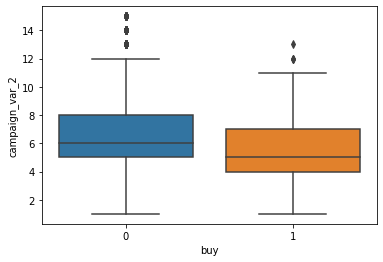

In [54]:
sns.boxplot(y= 'campaign_var_2' , x = 'buy' , data = train)

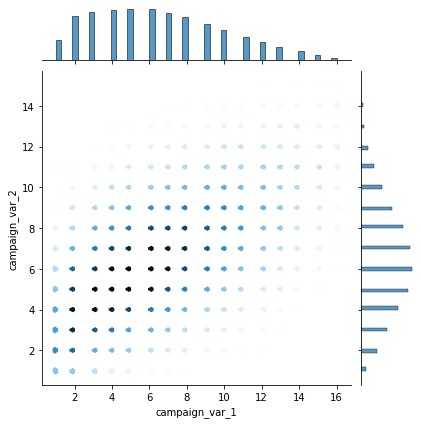

In [58]:
sns.jointplot(x= 'campaign_var_1' , y = 'campaign_var_2' , data = train,kind='hex')

In [222]:
train['created_at']=pd.to_datetime(train['created_at'])

In [223]:
train['day'] = train['created_at'].dt.day

In [224]:
train['date'] = train['created_at'].dt.week

In [225]:
train['month'] = train['created_at'].dt.month

In [226]:
train['dow'] = train['created_at'].dt.dayofweek

In [207]:
test['created_at']=pd.to_datetime(test['created_at'])
test['day'] = test['created_at'].dt.day
test['date'] = test['created_at'].dt.week
test['month'] = test['created_at'].dt.month
test['dow'] = test['created_at'].dt.dayofweek

In [227]:
train

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,...,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy,ir,cv,day,date,month,dow
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,...,0,0,0,0,9.000000,-1,1,53,1,4
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,...,0,0,0,0,12.436564,3,1,53,1,4
2,3,2021-01-01,9,3,3.0,2021-08-11,1,0,0,0,...,0,0,0,0,10.718282,6,1,53,1,4
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,...,0,0,0,0,9.000000,1,1,53,1,4
4,5,2021-01-01,4,6,2.0,2020-06-08,0,0,0,0,...,0,1,0,0,10.718282,6,1,53,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39156,39157,2021-12-31,11,11,2.0,2017-10-19,1,0,0,0,...,0,0,0,0,12.436564,0,31,52,12,4
39157,39158,2021-12-31,3,9,3.0,NaN,0,0,0,0,...,0,0,0,0,9.000000,10,31,52,12,4
39158,39159,2021-12-31,8,7,2.0,NaN,1,0,0,0,...,0,0,0,0,12.436564,3,31,52,12,4
39159,39160,2021-12-31,7,12,2.0,NaN,0,0,0,0,...,0,1,0,0,10.718282,11,31,52,12,4


In [228]:
df = train.drop(['id','created_at','signup_date'],axis=1)

In [208]:
test = test.drop(['id','created_at','signup_date'],axis=1)

In [213]:
test

,campaign_var_1,campaign_var_2,products_purchased,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,...,user_activity_var_11,user_activity_var_12,ir,cv,day,date,month,dow,cv1,cv2
0,2,2,2.0,1,1,0,0,0,1,0,...,1,0,14.154845,0,1,52,1,5,0,0
1,4,7,3.0,1,0,0,0,0,0,0,...,0,0,10.718282,7,1,52,1,5,1,2
2,8,7,2.0,0,0,0,0,1,1,0,...,0,0,10.718282,3,1,52,1,5,3,2
3,9,8,2.0,0,0,0,0,1,1,1,...,2,0,17.107338,13,1,52,1,5,4,3
4,4,5,2.0,1,0,0,0,0,0,0,...,0,0,10.718282,5,1,52,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13179,16,12,2.0,0,0,0,0,0,1,1,...,0,0,9.000000,0,30,13,3,2,5,5
13180,12,8,2.0,1,0,0,0,0,1,0,...,0,0,10.718282,0,30,13,3,2,5,3
13181,14,14,3.0,0,0,1,0,0,0,1,...,0,0,10.718282,0,30,13,3,2,5,5
13182,14,10,2.0,0,0,0,0,0,0,1,...,1,0,10.718282,4,30,13,3,2,5,4


In [229]:
from sklearn.preprocessing import KBinsDiscretizer
d1 = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')
df['cv1'] =d1.fit_transform(df['campaign_var_1'].values.reshape(-1,1)).astype(int)
df['cv2'] =d1.fit_transform(df['campaign_var_2'].values.reshape(-1,1)).astype(int)

In [209]:
test['cv1'] =d1.fit_transform(test['campaign_var_1'].values.reshape(-1,1)).astype(int)
test['cv2'] =d1.fit_transform(test['campaign_var_2'].values.reshape(-1,1)).astype(int)

In [230]:
target = df['buy']

train_df = df.drop(columns =['buy'])
test_df=test

In [211]:
def feature_importance(model, X_train):

    fI = model.feature_importances_
    
    print(fI)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, fI)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 27412 rows of holdout = 11749
[100]	valid_0's binary_logloss: 0.110099	valid_0's auc: 0.917074
[200]	valid_0's binary_logloss: 0.0994953	valid_0's auc: 0.921149
[300]	valid_0's binary_logloss: 0.0961343	valid_0's auc: 0.923335
[400]	valid_0's binary_logloss: 0.0949562	valid_0's auc: 0.924368
[500]	valid_0's binary_logloss: 0.0945742	valid_0's auc: 0.924407
LGB Val OOF AUC= 0.9246609071921064
####################################################################################################
[ 3402.81128757  3230.4864452    830.44134234  2415.4921131
 13954.22469211  2016.89027193 18484.13881494  3663.22692998
  1080.09432543   348.58555477  5432.22461736 30515.35997915
     0.         15830.50124182     0.         43771.37413582
  1870.88735617  2137.77201984  2937.35227148  1465.42209476
  1007.56841063  1493.98672121  1685.17532301]


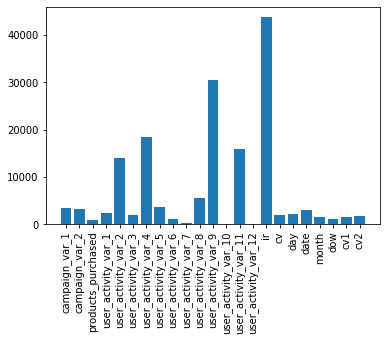

Fold 1
 rows of train = 27412 rows of holdout = 11749
[100]	valid_0's binary_logloss: 0.111943	valid_0's auc: 0.916518
[200]	valid_0's binary_logloss: 0.102303	valid_0's auc: 0.918916
[300]	valid_0's binary_logloss: 0.0992556	valid_0's auc: 0.920667
[400]	valid_0's binary_logloss: 0.0982888	valid_0's auc: 0.921399
[500]	valid_0's binary_logloss: 0.0979901	valid_0's auc: 0.921597
LGB Val OOF AUC= 0.9217463335753909
####################################################################################################
Fold 2
 rows of train = 27412 rows of holdout = 11749
[100]	valid_0's binary_logloss: 0.113888	valid_0's auc: 0.906269
[200]	valid_0's binary_logloss: 0.104569	valid_0's auc: 0.909521
[300]	valid_0's binary_logloss: 0.101735	valid_0's auc: 0.910484
[400]	valid_0's binary_logloss: 0.100762	valid_0's auc: 0.910921
LGB Val OOF AUC= 0.9110732386563555
####################################################################################################
Fold 3
 rows of train = 27412 

In [231]:
%%time
##LightGBM

cat_features = ['day', 'date', 'month', 'dow']
#cont_features = ['Balance']

probs_lgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])

    X_train_cv,y_train_cv = train_df.copy(), target.copy()

    sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.3,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = lgb.LGBMClassifier(boosting_type='gbdt',
                                 n_estimators=10000,
                                 max_depth=10,
                                 learning_rate=0.02,
                                 subsample=0.9,
                                 colsample_bytree=0.4,
                                 objective ='binary',
                                 random_state = 1,
                                 importance_type='gain',
                                 reg_alpha=2,
                                 reg_lambda=2
                                 #cat_features=cat_features
                                )        
        
        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['binary_logloss','auc'],
                    early_stopping_rounds=100)
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_lgb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        avg_loss.append(clf.best_score_['valid_0']['binary_logloss'])

        print ('LGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            feature_importance(clf,X_train_cv)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

  0%|          | 0/1 [00:00<?, ?it/s]

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 27412 rows of holdout = 11749
[0]	validation_0-auc:0.85860	validation_0-logloss:0.65818
[100]	validation_0-auc:0.91619	validation_0-logloss:0.10538
[200]	validation_0-auc:0.92323	validation_0-logloss:0.09534
[300]	validation_0-auc:0.92488	validation_0-logloss:0.09400
[378]	validation_0-auc:0.92451	validation_0-logloss:0.09409
XGB Val OOF AUC= 0.9255245289233924
####################################################################################################
[0.0067017  0.00792643 0.00533926 0.01879247 0.13727957 0.01867191
 0.19796349 0.02368028 0.00874143 0.00564049 0.04323338 0.30906337
 0.01669591 0.07708216 0.00863456 0.0724244  0.00587934 0.00569134
 0.00567796 0.00488046 0.00467876 0.0085611  0.00676018]


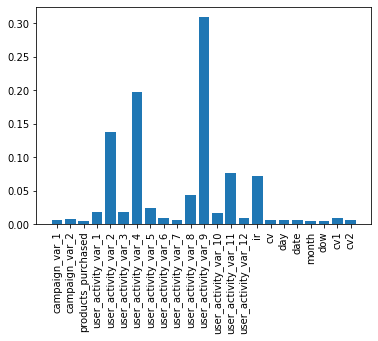

Fold 1
 rows of train = 27412 rows of holdout = 11749
[0]	validation_0-auc:0.85380	validation_0-logloss:0.65824
[100]	validation_0-auc:0.91459	validation_0-logloss:0.10731
[200]	validation_0-auc:0.92054	validation_0-logloss:0.09842
[300]	validation_0-auc:0.92105	validation_0-logloss:0.09780
[332]	validation_0-auc:0.92121	validation_0-logloss:0.09779
XGB Val OOF AUC= 0.9212600223092299
####################################################################################################
Fold 2
 rows of train = 27412 rows of holdout = 11749
[0]	validation_0-auc:0.85298	validation_0-logloss:0.65814
[100]	validation_0-auc:0.90658	validation_0-logloss:0.10943
[200]	validation_0-auc:0.91063	validation_0-logloss:0.10118
[300]	validation_0-auc:0.91085	validation_0-logloss:0.10040
[373]	validation_0-auc:0.91095	validation_0-logloss:0.10045
XGB Val OOF AUC= 0.9110125994744603
####################################################################################################
Fold 3
 rows of train 

In [232]:
%%time

##XGBM

probs_xgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.3 ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = xgb.XGBClassifier(n_estimators=1000,
                                max_depth=6,
                                learning_rate=0.04,
                                subsample=0.9,
                                colsample_bytree=0.35,
                                objective = 'binary:logistic',
                                random_state = 1
                               )        


        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['auc','logloss'],
                    early_stopping_rounds=50)
        
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_xgb +=clf.predict_proba(test_df)[:,1]

        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)
        
        avg_loss.append(clf.best_score)

        print ('XGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            
            feature_importance(clf,X_train_cv)
            
print("Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

  0%|          | 0/1 [00:00<?, ?it/s]

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 27412 rows of holdout = 11749
0:	learn: 0.6562556	test: 0.6563772	best: 0.6563772 (0)	total: 52.7ms	remaining: 8m 47s
100:	learn: 0.0981869	test: 0.1009674	best: 0.1009674 (100)	total: 6.63s	remaining: 10m 49s
200:	learn: 0.0904337	test: 0.0955107	best: 0.0955107 (200)	total: 13.8s	remaining: 11m 13s
300:	learn: 0.0868222	test: 0.0942891	best: 0.0942881 (299)	total: 20.2s	remaining: 10m 50s
400:	learn: 0.0843308	test: 0.0936958	best: 0.0936854 (398)	total: 26.5s	remaining: 10m 33s
500:	learn: 0.0819122	test: 0.0933227	best: 0.0933227 (500)	total: 33s	remaining: 10m 25s
600:	learn: 0.0792550	test: 0.0931599	best: 0.0931307 (570)	total: 39.7s	remaining: 10m 21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.093130677
bestIteration = 570

Shrink model to first 571 iterations.
CatBoost Val OOF AUC= 0.9263821615996766
[ 7.06168121  7.9753

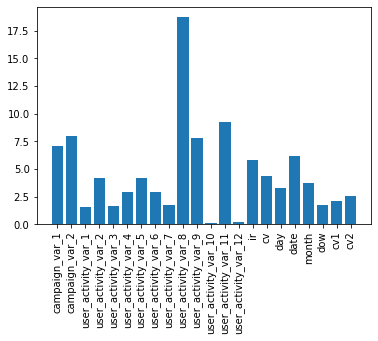

####################################################################################################
Fold 1
 rows of train = 27412 rows of holdout = 11749
0:	learn: 0.6547008	test: 0.6548316	best: 0.6548316 (0)	total: 76.5ms	remaining: 12m 44s
100:	learn: 0.0963555	test: 0.1031076	best: 0.1031076 (100)	total: 8.21s	remaining: 13m 24s
200:	learn: 0.0874631	test: 0.0985771	best: 0.0985771 (200)	total: 15.8s	remaining: 12m 48s
300:	learn: 0.0840164	test: 0.0979613	best: 0.0979563 (298)	total: 22.8s	remaining: 12m 16s
400:	learn: 0.0810695	test: 0.0977253	best: 0.0976984 (397)	total: 29.4s	remaining: 11m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.09764792878
bestIteration = 434

Shrink model to first 435 iterations.
CatBoost Val OOF AUC= 0.9206787845212875
####################################################################################################
Fold 2
 rows of train = 27412 rows of holdout = 11749
0:	learn: 0.6560115	test: 0.6561678	best: 0.6561678 (

In [131]:
%%time

##CatBoost

cat_features = ['day', 'date', 'month', 'dow']

#cont_features = ['Balance']

probs_cb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.3 ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = CatBoostClassifier(iterations=10000,
                                learning_rate=0.02,
                                random_strength=0.1,
                                depth=8,
                                loss_function='Logloss',
                                eval_metric='Logloss',
                                leaf_estimation_method='Newton',
                                random_state = 1,
                                cat_features =cat_features,
                                subsample = 0.9,
                                rsm = 0.8
                                )    

        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                   early_stopping_rounds=50,verbose = 100)

        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_cb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        print ('CatBoost Val OOF AUC=',roc)

        avg_loss.append(clf.best_score_['validation']['Logloss'])

        if i==0:
            
            feature_importance(clf,X_train_cv)

        print('#'*100)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

In [132]:
submission

,id,buy
0,39162,1
1,39163,1
2,39164,1
3,39165,1
4,39166,1
...,...,...
13179,52341,1
13180,52342,1
13181,52343,1
13182,52344,1


In [233]:
p1 =probs_lgb/5

p2 = probs_cb/5

p3 = probs_xgb/5

In [242]:
#pred = 0.3*p3+0.4*p2+0.3*p1
pred = p1

In [243]:
pred

array([0.96867498, 0.00322762, 0.02891415, ..., 0.00456399, 0.00813233,
       0.00126798])

In [244]:
out=pd.DataFrame(pred,columns=['buy'])

In [260]:
out1=out.copy()
out1['buy']=out1['buy'].apply(lambda x: 0 if x<0.5 else 1)

In [261]:
test1 = pd.read_csv("test_Wf7sxXF.csv")
final1=pd.concat([test1['id'],out1['buy']],axis=1)

In [262]:
final1['buy'].value_counts()

0    12789
1      395
Name: buy, dtype: int64

In [263]:
final1.to_csv('NN_1.csv',index=False)

In [264]:
final1

,id,buy
0,39162,1
1,39163,0
2,39164,0
3,39165,1
4,39166,0
...,...,...
13179,52341,0
13180,52342,0
13181,52343,0
13182,52344,0
